Importing the required packages

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature # This pacakge is used for LBP feature extraction
from sklearn import svm # This pacakge is used for svm classification
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline
import cv2
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)

Loading the **dataset**

In [38]:
import os
from os.path import isfile, join
import re

mypath = 'dataset_42028assg1_13918471'
categories = ['!', ')', '[', '+', '=', 'cos', 'div', 'sum', 'tan', 'times']
dataset = []
img_index_arr = []
# files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

def load_data():
    for category in categories:
        path = os.path.join(mypath, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img),0)
                new_array = cv2.resize(img_array, (28,28))
                dataset.append(new_array.flatten())
                img_index_arr.append(class_num)
            except Exception as e:
                print(e)


In [39]:
load_data()

Displaying examples from the dataset

Splitting the dataset into training and testing sets

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, img_index_arr)

In [41]:
# train a SVM clasifier on the training data
# Initialize the SVM model
print(np.shape(X_train))
print(np.shape(Y_train))

model = svm.SVC(kernel='rbf',C=100.0, random_state=42) # rbf Kernel
# Start training the SVM classifier
model.fit(X_train, Y_train)



(3750, 784)
(3750,)


SVC(C=100.0, random_state=42)

In [42]:
# Check the training accuray
print("Train set Accuracy: {:.2f}".format(model.score(X_train,Y_train)))

# Expected training set Accuracy 0.60

Train set Accuracy: 1.00


In [43]:
predictions=[]
predict_label=[]
# Exract LBP features for each test sample and classify it with the trained SVM classifier
for im_index in range(len(X_test)):
  imag = X_test[im_index]
  # Extract LBP feature
  # Perform classification
  prediction = model.predict(imag.reshape(1, -1))
  # Store the classfication result
  predictions.append(prediction)
  predict_label.append(Y_test[im_index])

In [44]:
accuracy = metrics.accuracy_score(Y_test, predictions)
print("Accuracy on test dataset:",accuracy)

Accuracy on test dataset: 0.9784


[[120   2   0   0   0   0   0   0   0   0]
 [  0 135   0   0   0   0   0   0   0   0]
 [  0   0 121   0   0   0   0   0   0   0]
 [  0   0   0 134   0   0   0   0   2   1]
 [  0   0   1   3 115   0   0   0   0   0]
 [  0   0   0   0   0 123   0   0   2   0]
 [  0   1   0   4   0   0 124   1   0   0]
 [  0   0   1   0   4   0   0 127   0   0]
 [  0   0   0   0   0   0   0   1 113   0]
 [  0   0   0   2   1   0   1   0   0 111]]


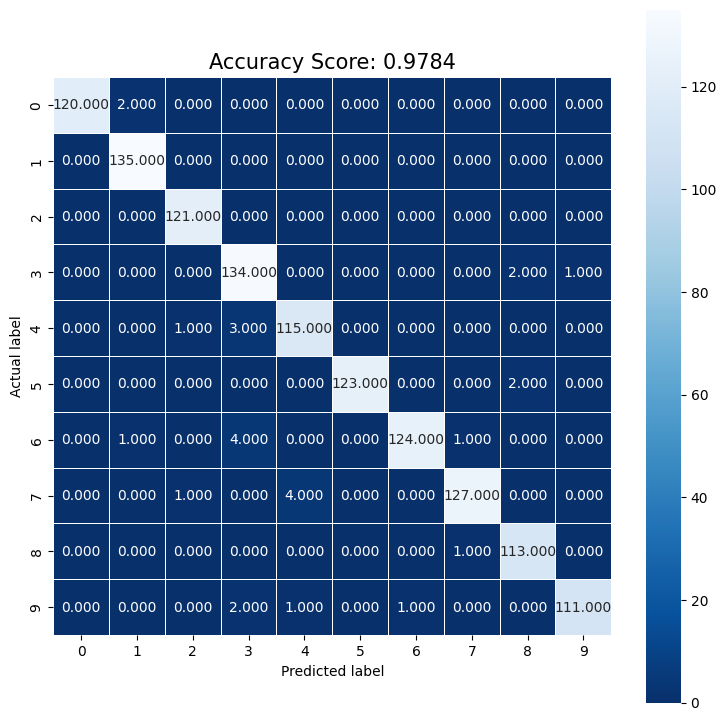

In [45]:
# plot the confusion matrix
cm  = metrics.confusion_matrix(Y_test, predictions)
print(cm)

# Plot confusion matrix using seaborn library
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [47]:
images = []
orig_labels=[]
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(Y_test)), size=(16,)):
  # classify the clothing
  test_img = (X_test[i])
  pred = model.predict(test_img.reshape(1, -1))[0]
  #prediction = model.predict(test_img.reshape(1, -1))
  label = categories[pred]
  orig_labels.append(categories[Y_test[i]])
  color = (0, 255, 0)
  test_img = cv2.merge([test_img] * 3)
  test_img = cv2.resize(test_img, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(test_img, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 2)
  images.append(test_img)

Extracting features from training dataset...
(3750, 324)
(3750,)
